In [1]:
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import matplotlib.patches as mpatches
%matplotlib inline

# Plot Parameters

In [2]:
#parameters
plotdir = "../results"
font = { 'size'   : 15}
plt.rc('font', **font)
markersize = 10 #12

#markers
colors = ['b','r','g','m','y','c']
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

#styledict
styledict = {"thorsten": {"fontsize_annotation": 10, "roof_color": 'gray', "legend_points_ncol": 2, "frameon": False}, 
             "charlene": {"fontsize_annotation": 15, "roof_color": 'k', "legend_points_ncol": 1, "frameon": True}}

# Plot Code

In [3]:
#plot roofs
def plot_roofs(fig, ax, xlim, ylim, styledict, scaling = 1.):
    #extract general settings
    fontsize_annotation = styledict["fontsize_annotation"] #10
    roof_color = styledict["roof_color"]
    
    #set up roofs
    #mem
    smemroofs = [828.758]
    smem_roof_name = ['HBM']
    #flops
    scomproofs_fp64 = [7068.86, 3535.79]
    #scomproofs_fp64 = [x*10**-3 for x in scomproofs_fp64]
    scomp_roof_name_fp64 = ['FMA (FP64)', 'No-FMA (FP64)']
    scomproofs_fp32 = [2.*x for x in scomproofs_fp64]
    scomp_roof_name_fp32 = ['FMA (FP32)', 'No-FMA (FP32)']
    scomproofs_fp16 = [125000.0] + [4.*x for x in scomproofs_fp64]
    scomp_roof_name_fp16 = ['Tensor Core (FP16)', 'FMA (FP16)', 'No-FMA (FP16)']
    scalingFactorForRoofs = scaling
    
    #resolution
    #nx = 10000
    xmin = xlim[0]
    xmax = xlim[1]
    ymin = ylim[0]
    ymax = ylim[1]
    nx = 10*xmax
    
    #set limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    #plot roofs:
    dx = (xmax-xmin)/nx
    for idm, smem in enumerate(smemroofs):
        
        #fp32
        for idc, scomp in enumerate(scomproofs_fp32):
            xvals = np.arange(xmin, xmax, dx)
            yvals = np.minimum(smem*xvals, np.tile(np.array(scomp),len(xvals)))
            ax.plot(xvals, yvals, c=roof_color, ls='-', lw='2')
            #find elbow
            optimize = minimize(fun=lambda x: np.abs(smem*x-scomp), x0=xmin, tol=1.e-10)
            xelb = optimize["x"][0]
            yelb = min(smem*xelb, scomp)
            if idm==0:
                #plot scomp
                label = scomp_roof_name_fp32[idc] + ': ' + '{0:.1f}'.format(float(scomp*10**-3)/scalingFactorForRoofs) + ' TFLOP/s'
                ax.annotate(label, xy=(xelb,scomp), xytext=(17,5), textcoords="offset points", color=roof_color, horizontalalignment='left', fontsize=fontsize_annotation)
        #fp16
        for idc, scomp in enumerate(scomproofs_fp16):
            xvals = np.arange(xmin, xmax, dx)
            yvals = np.minimum(smem*xvals, np.tile(np.array(scomp),len(xvals)))
            ax.plot(xvals, yvals, c=roof_color, ls='-', lw='2')
            if idm==0:
                #plot scomp
                label = scomp_roof_name_fp16[idc] + ': ' + '{0:.1f}'.format(float(scomp*10**-3)/scalingFactorForRoofs) + ' TFLOP/s'
                ax.annotate(label, xy=(xmax,scomp), xytext=(-5,5), textcoords="offset points", color=roof_color, horizontalalignment='right', fontsize=fontsize_annotation)
        
        #plot mem
        #find intersection
        scomp = scomproofs_fp16[0]
        yis = ymin
        xis = minimize(fun = lambda x: np.abs(min([smem*x,scomp])-yis), x0=xmin, tol=1.e-10)["x"][0]
        #find elbow
        optimize = minimize(fun=lambda x: np.abs(smem*x-scomp), x0=xmin, tol=1.e-10)
        xelb = optimize["x"][0]
        yelb = min(smem*xelb, scomp)
        #angle in plot coord system
        ang = np.rad2deg( np.arctan2(yelb-yis, xelb-xis) )
        #angle in figure coord system
        pts = np.array((xelb, yelb)).reshape((1,2))
        trans_ang = ax.transData.transform_angles(np.array((ang,)), pts)[0]
        #ax.plot(xis, yis, marker="o", ms=10)
        #ax.plot(xelb, yelb, marker="o", ms=10)
        label = smem_roof_name[idm] + ': ' + '{0:.1f}'.format(float(smem)/scalingFactorForRoofs) + ' GB/s'
        ax.annotate(label, xy=(xelb, yelb), xytext=(3,-5), color=roof_color, \
                rotation=trans_ang, rotation_mode='anchor', \
                horizontalalignment='right', \
                verticalalignment='top', \
                textcoords="offset points", \
                fontsize=fontsize_annotation)

In [4]:
#data dependent stuff
def plot_data(file_prefix, df, cmp=False):
    
    #pick style:
    style = styledict["thorsten"]
    
    AI     = list(df["DRAM AI"])
    FLOPs  = list(df["Performance GFlop/s"])
    labels = list(df['Name'])
    
    #figure stuff
    fig = plt.figure(1,figsize=(10.67,6.6))
    plt.clf()
    ax = fig.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Arithmetic Intensity [FLOP/Byte]')
    ax.set_ylabel('Performance [GFLOP/s]')
    xmin = -1 #np.floor(np.log(min(AI_l1))) #-2
    xmax = 3.5 #np.ceil(np.log(max(AI_dram)))
    #ymin = max(min([6500.0*0.5]+[0.5*x for x in FLOPs]), 500.0)
    ymin = 10
    ymax = 125000.0*5.5 #max(FLOPs)*2./scalingFactorForRoofs
    
    #some handles
    marker_handles = []
    
    #plot roofs
    plot_roofs(fig, ax, (10**xmin, 10**xmax), (ymin, ymax), style)
    
    if cmp:
        for i in range(0,len(AI)):
            ax.plot(float(AI[i]),float(FLOPs[i]),c=colors[i],marker=styles[i], ms=12)
    else:
        for i in range(0,len(AI)):
            # top 5 kernels in red dot
            if i < 5:
                ax.plot(float(AI[i]),float(FLOPs[i]),c='r',marker=styles[0], ms=12)
            # medium kernels in yellow
            elif i < 20:
                ax.plot(float(AI[i]),float(FLOPs[i]),c='gold',marker=styles[1], ms=10)
            # small (negligible) kernels in green
            else:
                ax.plot(float(AI[i]),float(FLOPs[i]),c='green',marker=styles[2], ms=8)

    #plt.show()
    #legend:
    if cmp:
        patch_handles = []
        for i in range(len(labels)):
            patch_handles.append(ax.plot([],[],color=colors[i],marker=styles[i],label=labels[i],linestyle='None',ms=12)[0])
        leg2 = plt.legend(handles = patch_handles,loc='upper left', scatterpoints = 1, frameon=style["frameon"])
    
    #save figure
    plt.tight_layout()
    plt.savefig(file_prefix+'.png')
    plt.savefig(file_prefix+'.eps')

In [5]:
#plot box
def plot_box(file_prefix, df):

    def byte2time(x):
        return x / byteroofs[0]


    def flop2time(y):
        return y / floproofs[-1]

    #pick style:
    style = styledict["thorsten"]
    fontsize_annotation = style["fontsize_annotation"]

    df[['FLOPs', 'DRAM Bytes']] /= 1e9
    
    lbytes  = list(df["DRAM Bytes"])
    lflops  = list(df["FLOPs"])
    ltime   = list(df["CUDA Time"])
    lcalls  = list(df["Invocations"])
    llabels = list(df["Name"])

    #figure stuff
    fig = plt.figure(1, figsize=(10, 10))
    plt.clf()
    ax = fig.gca()
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('GBytes')
    ax.set_ylabel('GFLOPs')

    #ax.grid(True, which="major", ls="--", lw=1)
    #ax.grid(True, which="minor", ls="--", lw=0.5)

    bmin = min(lbytes)
    bmax = max(lbytes)
    fmin = min(lflops)
    fmax = max(lflops)
    tmin = min(ltime)
    tmax = max(ltime)
    tmax = math.ceil(tmax)

    # kernel launch overhead is ~ 4.2 us
    overhead = 4.2e-6
    
    
    #mem
    byteroofs = [828.8, 2996.7, 14*1024]
    byteroofnames = ['HBM', 'L2', 'L1']

    #flops
    floproofs = [7669.1, 15158.2, 29181.6, 125000.0]
    floproofnames = ['FP64', 'FP32', 'FP16', 'TC']

    # max time ceilings
    mt_byteroof = byteroofs[0] * tmax
    mt_floproof = floproofs[-1] * tmax
    
    balance = floproofs[-1] / byteroofs[0]
    
    
    min_flop_ceiling, min_byte_ceiling = float("inf"), float("inf")
    
    # plot overheads
    for i in range(len(lcalls)):
        tmp_overhead = lcalls[i] * overhead
        
        # overhead ceilings
        oh_byteroof = byteroofs[0] * tmp_overhead
        oh_floproof = floproofs[-1] * tmp_overhead
        
        # plot memory ceilings
        ax.plot([oh_byteroof, oh_byteroof], [0, oh_floproof], c=colors[i], linestyle='--')
        # plot flop ceilings
        ax.plot([0, oh_byteroof], [oh_floproof, oh_floproof], c=colors[i], linestyle='--')
        
        min_flop_ceiling, min_byte_ceiling = min(min_flop_ceiling, oh_floproof), min(min_byte_ceiling, oh_byteroof)

    #some handles
    marker_handles = []
        
    max_flop_ceiling, max_byte_ceiling = 0.0, 0.0
    
    for i in range(len(lbytes)):
        ax.plot(float(lbytes[i]),float(lflops[i]), c=colors[i], marker=styles[0], linestyle='None', ms=markersize)
        
        local_balance = float(lflops[i]) / float(lbytes[i])

        flop_ceilings, byte_ceilings = [], []
        for flop in floproofs:
            flop_ceilings.append(ltime[i] * flop)
            byte_ceilings.append(ltime[i] * flop / local_balance)
            
        if local_balance > balance:
            flop_vertex = ltime[i] * floproofs[-1]
            byte_vertex = flop_vertex / local_balance
            
            label = floproofnames[-1]
            ax.annotate(label, xy=(byte_vertex, flop_vertex), xytext=(5,0), textcoords="offset points",
                        color=colors[i], horizontalalignment='left', fontsize=fontsize_annotation)
        else:
            byte_vertex = ltime[i] * byteroofs[0]
            flop_vertex = byte_vertex * local_balance
            
        ax.plot(byte_vertex,flop_vertex, c=colors[i], marker=styles[0], mfc='none', linestyle='None', ms=markersize)
        ax.plot([lbytes[i], byte_vertex], [lflops[i], flop_vertex], c=colors[i])
        #label = floproofnames[-1]
        
        min_flop_ceiling, min_byte_ceiling = min(min_flop_ceiling, lflops[i]), min(min_byte_ceiling, lbytes[i])
        max_flop_ceiling, max_byte_ceiling = max(max_flop_ceiling, flop_vertex), max(max_byte_ceiling, byte_vertex)

        for j in range(len(flop_ceilings)):
            if (lflops[i] <= flop_ceilings[j] < flop_vertex) and (lbytes[i] <= byte_ceilings[j] < byte_vertex):
                ax.plot(byte_ceilings[j],flop_ceilings[j], c=colors[i], marker=styles[0], linestyle='None', ms=5)
                label = floproofnames[j] #+ ' {0:.1f}'.format(float(flop_ceiling))
                ax.annotate(label, xy=(byte_ceilings[j], flop_ceilings[j]), xytext=(5,-10), textcoords="offset points",
                            color=colors[i], horizontalalignment='left', fontsize=fontsize_annotation)
    
    bmin = pow(10, math.log(min_byte_ceiling)//math.log(10))
    fmin = pow(10, math.log(min_flop_ceiling)//math.log(10)) 
    bmax = pow(10, math.log(max_byte_ceiling)//math.log(10) + 1)
    fmax = pow(10, math.log(max_flop_ceiling)//math.log(10) + 1)

    ax.plot([oh_byteroof, mt_byteroof], [oh_floproof, mt_floproof], c='k')

    bsecax = ax.secondary_xaxis('top', functions=(byte2time, flop2time))
    bsecax.set_xlabel('Byte time')
    
    fsecax = ax.secondary_yaxis('right', functions=(flop2time, byte2time))
    fsecax.set_ylabel('FLOP time')

    ax.set_xlim(bmin, bmax)
    ax.set_ylim(fmin, fmax)
    
    #legend 2:
    patch_handles = []
    for i in range(len(llabels)):
        patch_handles.append(ax.plot([],[],color=colors[i],marker=styles[i],label=llabels[i],linestyle='None',ms=12)[0])
    leg2 = plt.legend(handles = patch_handles,loc='upper left', scatterpoints = 1, frameon=style["frameon"])

    #title
    #if plot_label:
    #    ax.text(ax.get_xlim()[0]*1.1, ax.get_ylim()[1]*1.5, plot_label, horizontalalignment='left', verticalalignment='top')
   
    #plt.show()

    #save figure
    file_prefix = file_prefix+'_box'
    plt.tight_layout()
    plt.savefig(file_prefix+'.png')
    plt.savefig(file_prefix+'.eps')

# Load Data

In [6]:
datadir = "../results/tf_fp32_amp_fw"
ptdir   = "/global/homes/y/yswang/mlperf-deepcam/analysis"

selectkeys = ['Name', 'Invocations', 'CUDA Time', 'Performance GFlop/s', 'FLOPs', 'DRAM AI', 'DRAM Bytes']

tfcombineddf = pd.read_csv(os.path.join(datadir,"combined_profile.csv"))
ptcombineddf = pd.read_csv(os.path.join(ptdir,"combined.csv"))
tfprofiledf  = pd.read_csv(os.path.join(datadir,"full_profile.csv"))
ptprofiledf  = pd.read_csv(os.path.join(ptdir,"profile.csv"))

## Overview

In [7]:
tfcombineddf['Name'] = 'Tensorflow'
tfdf = tfcombineddf[selectkeys]

ptcombineddf['Name'] = 'PyTorch'
ptdf = ptcombineddf.loc[ptcombineddf['Pass'].str.contains("forward"), selectkeys].copy()

combineddf = ptdf.append(tfdf)

display(combineddf)

,Name,Invocations,CUDA Time,Performance GFlop/s,FLOPs,DRAM AI,DRAM Bytes
1,PyTorch,4782,0.615992,17808.638230,1.096998e+13,90.478692,1.212438e+11
0,Tensorflow,525,0.197169,54591.034436,1.076368e+13,231.336538,4.652825e+10


## HBM Roofline

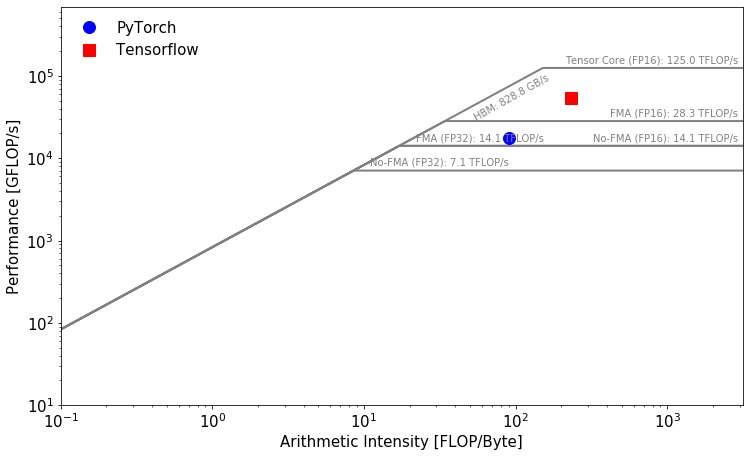

In [8]:
plot_data('cmp_overview_roofline', combineddf, True)

## Box

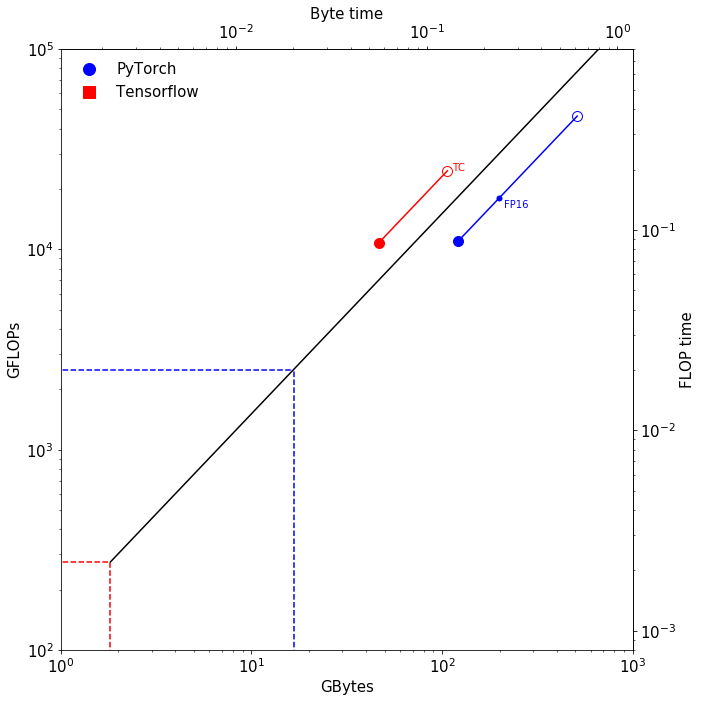

In [9]:
plot_box('cmp_overview_box', combineddf)

## TF HBM Roofline

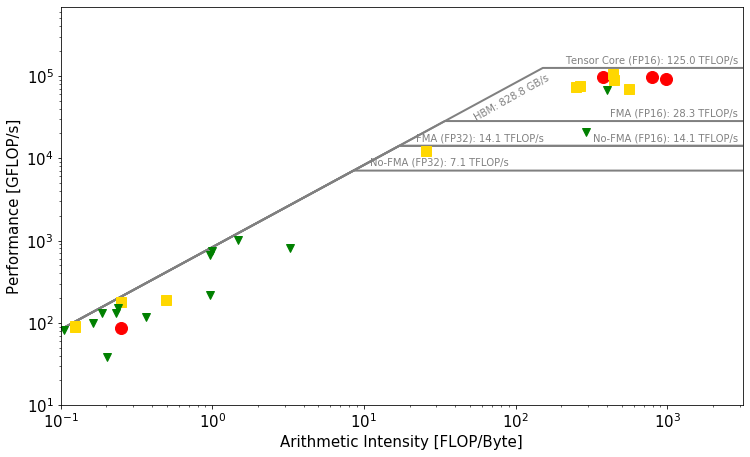

In [10]:
plot_data('tf_by_kernel', tfprofiledf)

In [11]:
#!mv *.png ../results
#!mv *.eps ../results